# Data Processing

This notebook demonstrates how preprocessing metagenomic data may aid their classification.

In [1]:
import os
import json
from stelaro.data import format, ncbi
import numpy as np
import random

DATA_DIRECTORY = "../data/"
SUMMARY_DIRECTORY = DATA_DIRECTORY + "ncbi_genome_summaries/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
BERTAX_DIRECTORY = DATA_DIRECTORY + "bertax/final/"
BERTAX_DATASET_DIRECTORY = BERTAX_DIRECTORY + "final_model_data_seperate_fasta_per_superkingdom/data/fass2/projects/fk_read_classification/dna_sequences/fragments/genomic_fragments_80_big/"
BERTAX_DOMAINS = (
    "Archaea_db.fa",
    "Bacteria_db.fa",
    "Eukaryota_db.fa",
    "Viruses_db.fa",
)
BERTAX_STATISTIC_DIRECTORY = BERTAX_DIRECTORY + "statistics/"
SEQUENCE_LENGTH = 1500
N_MINIMUM_READS_PER_TAXON = 10_000


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)


mkdir(BERTAX_STATISTIC_DIRECTORY)

## 1. Dataset Analysis

### 1.1. Obtain Taxa

In [6]:
tax_ids = set()
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                tax_ids.add(tax_id)

parents, ranks = ncbi.get_all_taxonomy_parents(
    NCBI_TAXONOMY_DIRECTORY + "nodes.dmp",
    NCBI_TAXONOMY_DIRECTORY + "merged.dmp",
)
names = ncbi.taxid_to_names(NCBI_TAXONOMY_DIRECTORY + "names.dmp", set(parents.keys()))
lineages = ncbi.resolve_taxonomy(parents, ranks, tax_ids, names)


def get_level_0(tax_id):
    if tax_id not in lineages:
        print(tax_id)
        return None
    for level in lineages[tax_id]:
        if level[-1] == "domain":
            return level[1]
    for level in lineages[tax_id]:
        if level[-1] == "realm":
            return "Viruses"
    return None


def get_level_1(tax_id):
    if tax_id not in lineages:
        print(tax_id)
        return None
    for level in lineages[tax_id]:
        if level[-1] == "phylum":
            return level[1]
    return None


def get_taxon(line):
    tax_id = line.strip()
    tax_id = tax_id.replace(">", "")
    tax_id = tax_id.split(" ")[0]
    domain = get_level_0(tax_id)
    phylum = get_level_1(tax_id)
    if domain and phylum:
        current_taxon = (domain, phylum)
    else:
        current_taxon = None
    return current_taxon


def get_mappings(file: str) -> dict:
    taxa = {}
    total = 0
    retained = 0
    current_taxon = None
    with open(file, "r") as f:
        for line in f:
            if line.startswith(">"):
                total += 1
                current_taxon = get_taxon(line)
            elif current_taxon:
                sequence = line.strip().upper()
                characters = set(sequence)
                if len(characters) == 4:
                    retained += 1
                    if current_taxon in taxa:
                        taxa[current_taxon] += 1
                    else:
                        taxa[current_taxon] = 1
    print(f"{retained} / {total}")
    return taxa

taxa = {}
for domain in BERTAX_DOMAINS:
    taxa |= get_mappings(BERTAX_DATASET_DIRECTORY + domain)

Taxon 1740162 is nameless.
Taxon 1588685 is nameless.
Taxon 1980519 is nameless.
Taxon 1986224 is nameless.
Taxon 1535802 is nameless.
Taxon 55097 is nameless.
Taxon 1980494 is nameless.
Taxon 11623 is nameless.
Taxon 2487073 is nameless.
Taxon 35310 is nameless.
Taxon 1759437 is nameless.
Taxon 35306 is nameless.
Taxon 743685 is nameless.
Taxon 85643 is nameless.
Taxon 2169992 is nameless.
Taxon 11191 is nameless.
Taxon 2546450 is nameless.
Taxon 1979163 is nameless.
Taxon 1979166 is nameless.
Taxon 122203 is nameless.
Taxon 740710 is nameless.
Taxon 623144 is nameless.
Taxon 12332 is nameless.
Taxon 62928 is nameless.
Taxon 1547445 is nameless.
Taxon 63330 is nameless.
Taxon 218387 is nameless.
Taxon 42764 is nameless.
Taxon 319236 is nameless.
Taxon 287094 is nameless.
Taxon 1673076 is nameless.
Taxon 55096 is nameless.
Taxon 35302 is nameless.
Taxon 262071 is nameless.
Taxon 220622 is nameless.
Taxon 207246 is nameless.
Taxon 1637841 is nameless.
Taxon 1980486 is nameless.
Taxon 11

In [7]:
total = 0
n_sequences = 0
n_taxa = 0
retained = []
for t, n in taxa.items():
    total += n
    if n >= N_MINIMUM_READS_PER_TAXON:
        print(t, n)
        n_sequences += n
        n_taxa += 1
        retained.append(t)
    else:
        print(f"{t} dropped ({n})")
delta = total - n_sequences
print(f"{n_sequences} / {total} reads ({delta} dropped). {n_taxa} taxa.")

mappings = {}
for i, taxon in enumerate(sorted(retained)):
    mappings[str(i)] = taxon
with open(BERTAX_STATISTIC_DIRECTORY + "map.json", "w") as f:
    json.dump(mappings, f, indent=4)

reversed_map = {v: k for k, v in mappings.items()}

('Archaea', 'Thermoproteota') 121632
('Archaea', 'Methanobacteriota') 312457
('Archaea', 'Nitrososphaerota') 59890
('Archaea', 'Thermoplasmatota') 41128
('Bacteria', 'Pseudomonadota') 576465
('Bacteria', 'Bacillota') 175591
('Bacteria', 'Bdellovibrionota') 34491
('Bacteria', 'Thermodesulfobacteriota') 56957
('Bacteria', 'Actinomycetota') 324374
('Bacteria', 'Campylobacterota') 28549
('Bacteria', 'Cyanobacteriota') 71022
('Bacteria', 'Fusobacteriota') 16581
('Bacteria', 'Chloroflexota') 59196
('Bacteria', 'Aquificota') 10525
('Bacteria', 'Bacteroidota') 123146
('Bacteria', 'Verrucomicrobiota') 26406
('Bacteria', 'Deinococcota') 29335
('Bacteria', 'Chlamydiota') 22473
('Bacteria', 'Lentisphaerota') 10942
('Bacteria', 'Mycoplasmatota') 47952
('Bacteria', 'Planctomycetota') 74762
('Bacteria', 'Chlorobiota') 13792
('Bacteria', 'Nitrospirota') 16852
('Bacteria', 'Spirochaetota') 36380
('Bacteria', 'Thermotogota') 32696
('Bacteria', 'Gemmatimonadota') 13353
('Bacteria', 'Elusimicrobiota') dro

In [8]:
y = np.zeros(n_sequences, dtype=np.uint16)
i = 0

for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        current_taxon = None
        for line in f:
            if line.startswith(">"):
                total += 1
                current_taxon = get_taxon(line)
            elif current_taxon in reversed_map:
                taxon_index = reversed_map[current_taxon]
                sequence = line.strip().upper()
                characters = set(sequence)
                if len(characters) == 4:
                    y[i] = taxon_index
                    i += 1

print(f"Expected {n_sequences}, read {i}. Difference: {n_sequences - i}.")

np.save(BERTAX_STATISTIC_DIRECTORY + "y.npy", y)

Expected 5294663, read 5294663. Difference: 0.


[ 312457   59890   41128  121632  324374   10525  175591  123146   34491
   28549   22473   13792   59196   71022   29335   16581   13353   10942
   47952   21961   16852   74762  576465   13160   36380   56957   32696
   26406   77703  144519  205272   41400   60635   24785 1280886   26851
   21456   87372   28161   27662   18269  625913   21632   23007   39710
   37411   47118   25148   57685]
Total N reads: 5294663
Minimum N reads: 10525 - Maximum N reads: 1280886


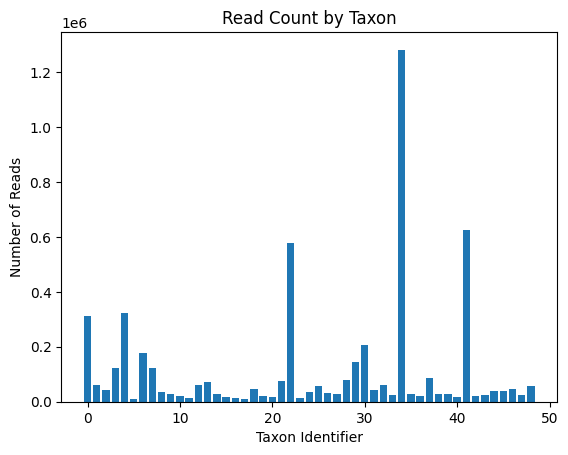

In [9]:
counts = np.bincount(y)
print(counts)
print(f"Total N reads: {sum(counts)}")
print(f"Minimum N reads: {min(counts)} - Maximum N reads: {max(counts)}")

import matplotlib.pyplot as plt
plt.bar(list(range(len(counts))), counts)
plt.xlabel("Taxon Identifier")
plt.ylabel("Number of Reads")
plt.title("Read Count by Taxon")
plt.show()

### 1.2. Create Distinct Sets

In [11]:
y = np.load(BERTAX_STATISTIC_DIRECTORY + "y.npy")
N = y.shape[0]

with open(BERTAX_STATISTIC_DIRECTORY + "map.json", "r") as f:
    mappings = json.load(f)
reversed_map = {tuple(v): k for k, v in mappings.items()}

In [18]:
random.seed(7)


def plan_datasets(test_minimum: int, train_maximum: int, validation_fraction: float) -> tuple:
    """Split read IDs into test, train, and validation sets.

    Args:
        test_minimum: Minimum number of reads in each taxon for the test set.
        train_maximum: Maximum number of reads per taxon in the train set.
        validation_fraction: Fraction of training reads to use for validation.
    """
    taxon_to_read_IDs = {k: [] for k in mappings}
    i = 0
    # Find identifiers
    for domain in BERTAX_DOMAINS:
        with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
            current_taxon = None
            for line in f:
                if line.startswith(">"):
                    current_taxon = get_taxon(line)
                elif current_taxon in reversed_map:
                    taxon_index = reversed_map[current_taxon]
                    sequence = line.strip().upper()
                    characters = set(sequence)
                    if len(characters) == 4:
                        taxon_to_read_IDs[taxon_index].append(i)
                        i += 1
    # Select test and train data
    train = {k: [] for k in mappings}
    validation = {k: [] for k in mappings}
    test = {k: [] for k in mappings}
    for taxon in taxon_to_read_IDs:
        random.shuffle(taxon_to_read_IDs[taxon])
        test[taxon] = taxon_to_read_IDs[taxon][:test_minimum]
        train_data = taxon_to_read_IDs[taxon][test_minimum:train_maximum + test_minimum]
        cutoff = int(len(train_data) * validation_fraction)
        train[taxon] = train_data[cutoff:]
        validation[taxon] = train_data[:cutoff]
    return train, validation, test

In [ ]:
M = SEQUENCE_LENGTH // 4  # Encode on tetramers to save memory.
datasets = plan_datasets(2000, 30_000, 0.05)

for dataset, name in zip(datasets, ("train", "validation", "test")):
    mkdir(BERTAX_DIRECTORY + name + "/")
    elements = set()
    for taxon in dataset:
        elements.update(dataset[taxon])
    N = len(elements)
    x = np.zeros((N, M), dtype=np.uint8)
    y = np.zeros(N, dtype=np.uint16)
    i = 0
    local_i = 0
    for domain in BERTAX_DOMAINS:
        with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
            current_taxon = None
            for line in f:
                if line.startswith(">"):
                    total += 1
                    tax_id = line.strip()
                    tax_id = tax_id.replace(">", "")
                    tax_id = tax_id.split(" ")[0]
                    domain = get_level_0(tax_id)
                    phylum = get_level_1(tax_id)
                    if domain and phylum:
                        current_taxon = (domain, phylum)
                    else:
                        current_taxon = None
                elif current_taxon in reversed_map:
                    taxon_index = reversed_map[current_taxon]
                    sequence = line.strip().upper()
                    characters = set(sequence)
                    if len(characters) == 4:
                        if i in elements:
                            encoding = format.encode_tetramer(sequence)
                            x[local_i] = encoding
                            y[local_i] = taxon_index
                            local_i += 1
                        i += 1
    assert local_i == N
    np.save(BERTAX_DIRECTORY + name + "/x.npy", x)
    np.save(BERTAX_DIRECTORY + name + "/y.npy", y)

## 2. One-Shot Classification

In [2]:
BERTAX_TRAIN = BERTAX_DIRECTORY + "train/"
BERTAX_VALIDATION = BERTAX_DIRECTORY + "validation/"
BERTAX_TEST = BERTAX_DIRECTORY + "test/"

import numpy as np
from torch import tensor
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch import bincount
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from time import time
from typing import Callable

from stelaro.data import format
from stelaro import models
from stelaro.models import feedforward, autoencoder, transformer, hybrid

LENGTH = 1500
BATCH_SIZE = 128


train_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_TRAIN),
    batch_size=BATCH_SIZE,
    shuffle=True
)
validation_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_VALIDATION),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data = DataLoader(
    models.SyntheticTetramerDataset(BERTAX_TEST),
    batch_size=BATCH_SIZE,
    shuffle=True
)

with open(BERTAX_DIRECTORY + "statistics/map.json", "r") as f:
    mapping = json.load(f)


def benchmark(
        classifier: models.BaseClassifier,
        name: str,
        max_epochs: int = 20
    ):
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1, validation_losses = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=max_epochs,
        patience=3,
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="Training")
        ax[0].plot(x, validation_losses, label="Validation")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Normalized Loss Against Epochs")
        ax[0].legend()
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test results: {rounded_result}")
    return classifier

### 2.1. Baseline

100%|██████████| 9196/9196 [00:18<00:00, 507.15it/s]


Training took 18.134 s.
Test results: [0.24601, 0.016713]


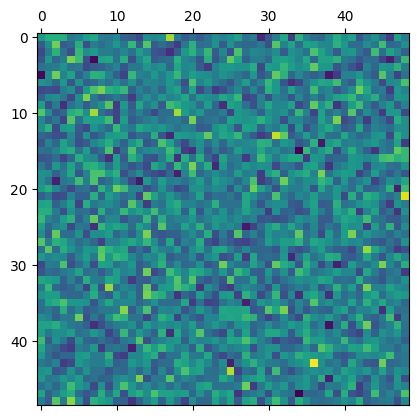

[[45. 49. 49. 49. 39. 41. 46. 48. 40. 39. 42. 35. 34. 31. 43. 42. 43. 60. 40. 34. 37. 34. 38. 43. 41. 43. 47. 38. 40. 26. 33. 40. 48. 29. 50. 41. 37. 36. 42. 49. 43. 47. 33. 39. 44. 37. 29. 47. 40.]
 [34. 43. 56. 34. 36. 49. 32. 40. 37. 40. 45. 39. 51. 35. 54. 34. 37. 34. 29. 39. 50. 37. 38. 44. 34. 44. 37. 36. 36. 39. 32. 54. 41. 47. 37. 47. 46. 42. 42. 50. 45. 37. 37. 43. 39. 52. 36. 37. 43.]
 [31. 40. 50. 38. 32. 51. 43. 45. 40. 40. 38. 42. 38. 46. 41. 33. 32. 27. 34. 45. 50. 41. 51. 34. 42. 32. 53. 38. 42. 41. 39. 43. 34. 44. 42. 38. 53. 47. 42. 34. 44. 45. 38. 34. 52. 37. 47. 42. 35.]
 [33. 45. 36. 40. 57. 52. 32. 22. 47. 48. 38. 49. 32. 42. 48. 34. 36. 37. 50. 42. 40. 33. 49. 33. 39. 55. 48. 35. 40. 40. 36. 46. 47. 45. 41. 48. 36. 47. 47. 50. 39. 38. 33. 37. 37. 30. 25. 35. 51.]
 [38. 39. 40. 44. 38. 39. 31. 34. 35. 38. 41. 33. 39. 39. 45. 42. 44. 36. 48. 42. 43. 34. 29. 41. 45. 45. 44. 44. 49. 31. 46. 45. 51. 46. 43. 45. 55. 45. 45. 33. 38. 33. 29. 41. 36. 45. 44. 50. 40.]
 [22.

In [ ]:
model = benchmark(
    models.RandomClassifier(),
    "Random Classifier",
)
model.n_classes = len(mapping)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

### 2.2. CNN

Number of parameters: 35_970_508


100%|██████████| 9196/9196 [04:52<00:00, 31.47it/s]


1/20 T loss: 0.021. V loss: 0.019. F1: [0.71736, 0.37742]. Patience: 3


100%|██████████| 9196/9196 [04:53<00:00, 31.34it/s]


2/20 T loss: 0.017. V loss: 0.018. F1: [0.78048, 0.47116]. Patience: 3


100%|██████████| 9196/9196 [04:54<00:00, 31.24it/s]


3/20 T loss: 0.016. V loss: 0.019. F1: [0.74431, 0.4239]. Patience: 2


100%|██████████| 9196/9196 [04:58<00:00, 30.77it/s]


4/20 T loss: 0.016. V loss: 0.017. F1: [0.8102, 0.50233]. Patience: 2


100%|██████████| 9196/9196 [04:58<00:00, 30.84it/s]


5/20 T loss: 0.015. V loss: 0.016. F1: [0.82107, 0.52682]. Patience: 2


100%|██████████| 9196/9196 [04:56<00:00, 31.05it/s]


6/20 T loss: 0.015. V loss: 0.017. F1: [0.7957, 0.51155]. Patience: 1


100%|██████████| 9196/9196 [04:56<00:00, 31.06it/s]


7/20 T loss: 0.015. V loss: 0.017. F1: [0.81621, 0.51502]. Patience: 0
The model is overfitting; stopping early.
Training took 2151.032 s.


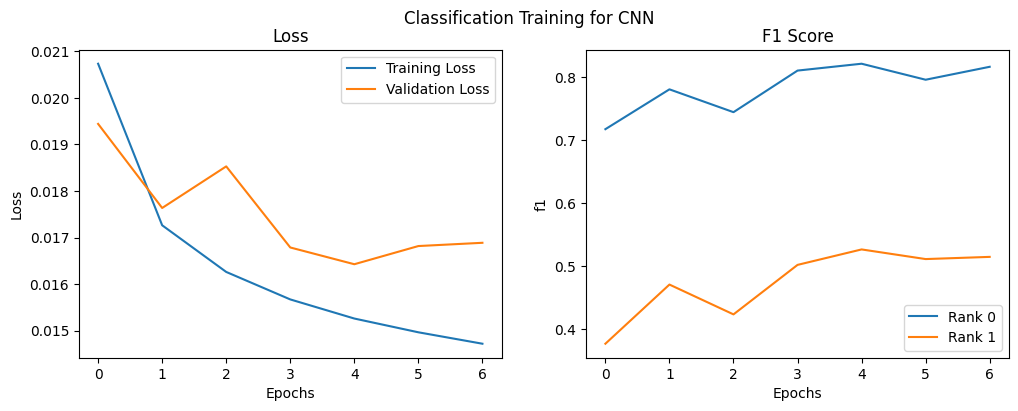

d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classe

Test results: [0.81605, 0.52799]


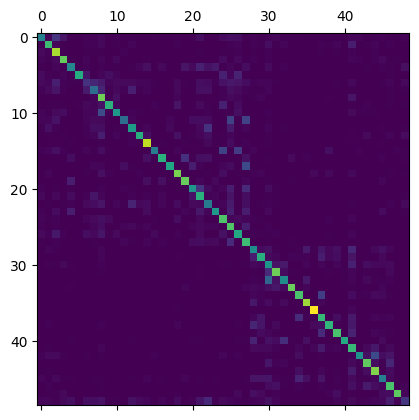

[[ 850.   27.  301.  100.   11.    4.   21.   19.   43.    6.   21.    9.   12.    1.    1.   11.    3.    0.   15.    2.   12.   69.    0.   13.   56.   83.   75.    8.   21.    3.   21.   33.    8.    8.    9.    0.    0.    5.    3.    4.    1.   31.   24.    6.    8.   19.    4.    2.   17.]
 [   4. 1332.   29.    9.    0.    0.   20.   17.   40.    2.    8.    6.   34.    2.    0.    0.    0.    0.   16.    0.    0.    1.    0.    0.    2.   18.   23.    4.   17.    8.   71.    8.   30.    0.    0.    2.    6.   16.    8.   34.    1.  152.    4.    8.   37.    5.   18.    1.    7.]
 [  49.   17. 1687.   13.    2.    0.   14.   14.    9.    0.    6.   17.    2.    0.    0.    2.    0.    0.    1.    1.    0.   11.    1.    0.   11.   10.   19.    0.    9.    4.   22.    3.    0.    0.    2.    0.    0.   10.    2.    8.    0.   17.    4.    1.   17.    6.    4.    1.    4.]
 [  30.   14.   47. 1475.    0.    1.   26.    0.   32.    1.   44.    0.    5.    2.    8.    4.    0.    0.

In [3]:
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d)
from torch import stack, tensor, float32, argmax
from torch.func import vmap
import torch.nn.functional as F


class CNN_2_dropout_token(Module):
    def __init__(self, N, M):
        super(CNN_2_dropout_token, self).__init__()
        self.conv = Sequential(
            Conv1d(4, 32, kernel_size=7, padding=3),
            ReLU(),
            Conv1d(32, 64, kernel_size=5, padding=2),
            ReLU(),
            Conv1d(64, 128, kernel_size=3, padding=1),
            ReLU(),
        )
        n = N * 4
        self.fc = Sequential(
            Flatten(),
            Dropout(0.2),
            Linear(n * 128, int(N / 2)),
            ReLU(),
            Dropout(0.2),
            Linear(int(N / 2), 128),
            ReLU(),
            Dropout(0.2),
            Linear(128, M)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x.float()


model = benchmark(
    feedforward.Classifier(
        LENGTH // 4,
        mapping,
        "cuda",
        CNN_2_dropout_token,
        format.to_channels),
    "CNN",
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

### 2.3. Transformer

Number of parameters: 880_177


100%|██████████| 9196/9196 [30:05<00:00,  5.09it/s]


1/6 T loss: 0.01511. V loss: 0.01279. F1: [0.81243, 0.57826]. Patience: 3


100%|██████████| 9196/9196 [30:16<00:00,  5.06it/s]


2/6 T loss: 0.01209. V loss: 0.01203. F1: [0.83438, 0.61208]. Patience: 3


100%|██████████| 9196/9196 [30:32<00:00,  5.02it/s]


3/6 T loss: 0.01139. V loss: 0.01133. F1: [0.85509, 0.64255]. Patience: 3


100%|██████████| 9196/9196 [30:32<00:00,  5.02it/s]


4/6 T loss: 0.01101. V loss: 0.01105. F1: [0.86597, 0.65503]. Patience: 3


100%|██████████| 9196/9196 [29:58<00:00,  5.11it/s]


5/6 T loss: 0.01075. V loss: 0.01083. F1: [0.86667, 0.65875]. Patience: 3


100%|██████████| 9196/9196 [30:17<00:00,  5.06it/s]


6/6 T loss: 0.01056. V loss: 0.01070. F1: [0.87418, 0.66521]. Patience: 3
Training took 11778.078 s.


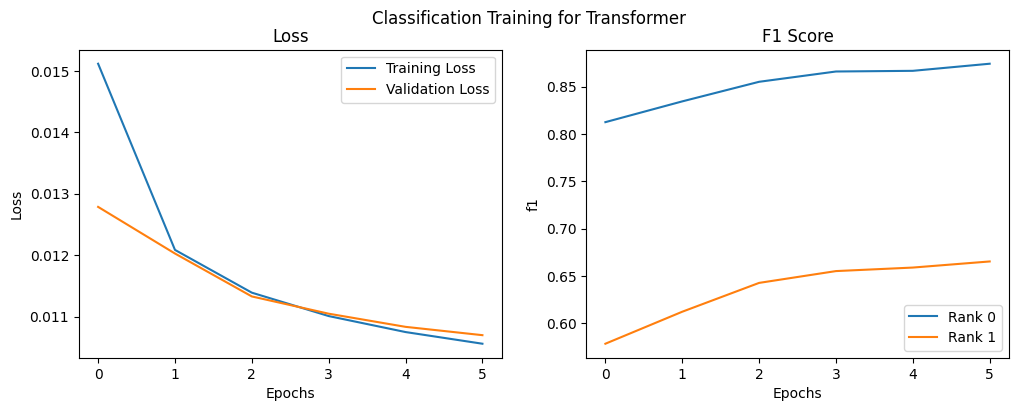

Test results: [0.87746, 0.69038]


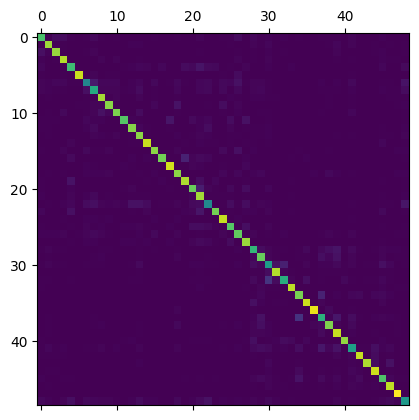

[[1388.    9.   67.   55.   11.    1.   12.   48.   14.    7.    8.    5.    5.    7.    1.   10.    0.    3.   13.    0.    7.   28.    3.    4.   12.   13.   56.    3.   33.    8.   20.    4.   16.    5.    9.    1.    2.   11.   12.   15.    1.   27.    6.    0.    7.   21.    2.    4.    6.]
 [   5. 1659.   19.   13.    3.    1.    4.   13.    4.    2.    4.    0.   17.   17.    0.    2.    0.    1.    5.    0.    0.    1.    5.    0.    1.    8.    3.    1.   23.   13.   32.    6.    7.    0.    1.    4.    2.    7.    8.   36.    1.   28.    0.    3.   14.    6.   11.    2.    8.]
 [  77.   20. 1642.   12.    4.    0.   11.   25.    6.    2.    6.    4.    5.    6.    0.    1.    0.    0.    0.    0.    7.   15.    1.    1.    2.    6.   14.    1.   12.    3.   18.    2.    8.    0.    3.    0.    0.    5.    3.   23.    1.    3.    4.    0.    8.   21.    6.    4.    8.]
 [  20.    2.   10. 1720.    0.    2.    6.    5.   26.    1.   28.    0.    5.   14.    0.    6.    0.    0.

In [4]:
from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)


class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=4,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=4)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, format.to_tetramers),
    "Transformer",
    max_epochs=6
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

### 2.4. Autoencoders

Number of parameters: 73_430_095


100%|██████████| 9196/9196 [05:45<00:00, 26.64it/s]


1/20 T loss: 0.00991. V loss: 0.00904. F1: [0.75798, 0.45015]. Patience: 3


100%|██████████| 9196/9196 [06:01<00:00, 25.46it/s]


2/20 T loss: 0.00778. V loss: 0.00822. F1: [0.82284, 0.55703]. Patience: 3


100%|██████████| 9196/9196 [06:08<00:00, 24.92it/s]


3/20 T loss: 0.00710. V loss: 0.00785. F1: [0.8232, 0.58458]. Patience: 3


100%|██████████| 9196/9196 [06:08<00:00, 24.96it/s]


4/20 T loss: 0.00660. V loss: 0.00774. F1: [0.85039, 0.61506]. Patience: 3


100%|██████████| 9196/9196 [06:08<00:00, 24.96it/s]


5/20 T loss: 0.00616. V loss: 0.00802. F1: [0.83835, 0.59645]. Patience: 2


100%|██████████| 9196/9196 [06:00<00:00, 25.53it/s]


6/20 T loss: 0.00577. V loss: 0.00827. F1: [0.81767, 0.57895]. Patience: 1


100%|██████████| 9196/9196 [05:57<00:00, 25.71it/s]


7/20 T loss: 0.00548. V loss: 0.00815. F1: [0.84603, 0.59513]. Patience: 0
The model is overfitting; stopping early.
Training took 2617.112 s.


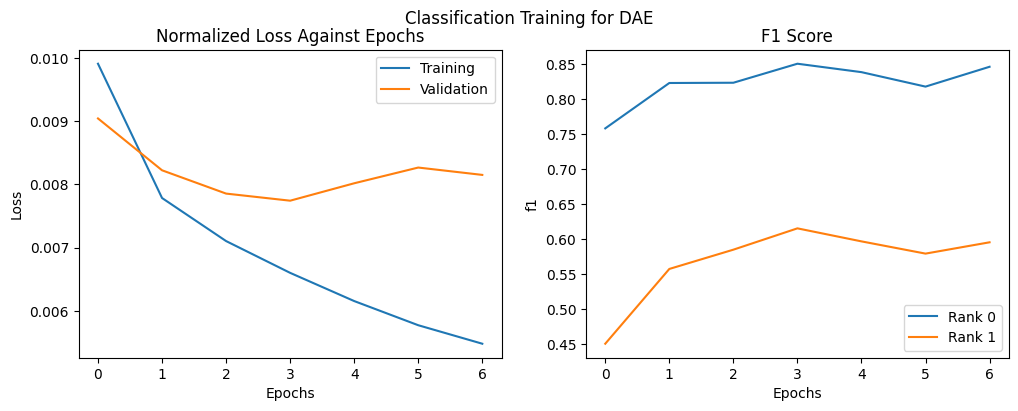

Test results: [0.84448, 0.614]


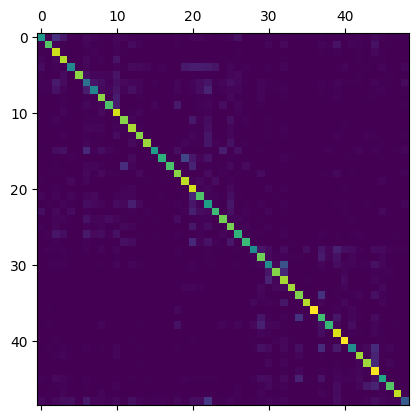

[[ 991.   10.  251. ...    3.    9.    8.]
 [   2. 1376.   33. ...   10.    0.    7.]
 [  14.   11. 1729. ...    3.    1.    3.]
 ...
 [   1.    2.   11. ... 1372.    1.    7.]
 [   1.    9.    6. ...    3. 1683.    1.]
 [  41.   13.   42. ...   18.   17.  545.]]


In [ ]:
from torch import clamp, tensor
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d, LeakyReLU, ConvTranspose1d, Sigmoid)
from torch import stack, tensor, float32
from torch.func import vmap
import torch.nn.functional as F


class Unsqueeze(Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x.unsqueeze(self.dim)


class DAE_1(Module):
    """Denoising autoencoder 1."""
    def __init__(self, N, M):
        super(DAE_1, self).__init__()
        LATENT_SPACE_SIZE = 128
        self.encoder = Sequential(
            Conv1d(4, 32, kernel_size=5, padding=2),
            LeakyReLU(),
            MaxPool1d(kernel_size=2),
            Conv1d(32, 64, kernel_size=3, padding=1),
            LeakyReLU(),
            Flatten(),
            Linear(N * 64 // 2, N),
            LeakyReLU(),
            Linear(N, LATENT_SPACE_SIZE),
            LeakyReLU(),
        )
        self.decoder = Sequential(
            Linear(LATENT_SPACE_SIZE, N // 2),
            LeakyReLU(),
            Linear(N // 2, N),
            LeakyReLU(),
            Unsqueeze(1),
            ConvTranspose1d(1, 4, kernel_size=3, stride=1, padding=1),
            LeakyReLU(),
            Sigmoid(),
        )
        self.classifier = Linear(LATENT_SPACE_SIZE, M)

    def forward(self, x):
        if self.training:
            x_noisy = autoencoder.add_masking_noise(x, dropout_prob=0.2)
            x = clamp(x_noisy, 0.0, 1.0)
        latent = self.encoder(x)
        classification = self.classifier(latent)
        reconstruction = self.decoder(latent)
        return classification.float(), reconstruction.float()


model = benchmark(
    autoencoder.Classifier(LENGTH, mapping, "cuda", DAE_1, format.to_channels),
    "DAE",
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

### 2.5. Transformer / Autoencoder Hybrid Model

Number of parameters: 1_492_568


100%|██████████| 9196/9196 [30:20<00:00,  5.05it/s]


1/6 T loss: 0.00834. V loss: 0.00755. F1: [0.79947, 0.54627]. Patience: 3


100%|██████████| 9196/9196 [30:39<00:00,  5.00it/s]


2/6 T loss: 0.00682. V loss: 0.00679. F1: [0.83707, 0.6094]. Patience: 3


100%|██████████| 9196/9196 [30:54<00:00,  4.96it/s]


3/6 T loss: 0.00644. V loss: 0.00641. F1: [0.86373, 0.64309]. Patience: 3


100%|██████████| 9196/9196 [31:07<00:00,  4.92it/s]


4/6 T loss: 0.00624. V loss: 0.00623. F1: [0.8658, 0.66165]. Patience: 3


100%|██████████| 9196/9196 [31:07<00:00,  4.92it/s]


5/6 T loss: 0.00611. V loss: 0.00614. F1: [0.87079, 0.66635]. Patience: 3


100%|██████████| 9196/9196 [31:10<00:00,  4.92it/s]


6/6 T loss: 0.00601. V loss: 0.00612. F1: [0.87532, 0.66188]. Patience: 2
Training took 11468.814 s.


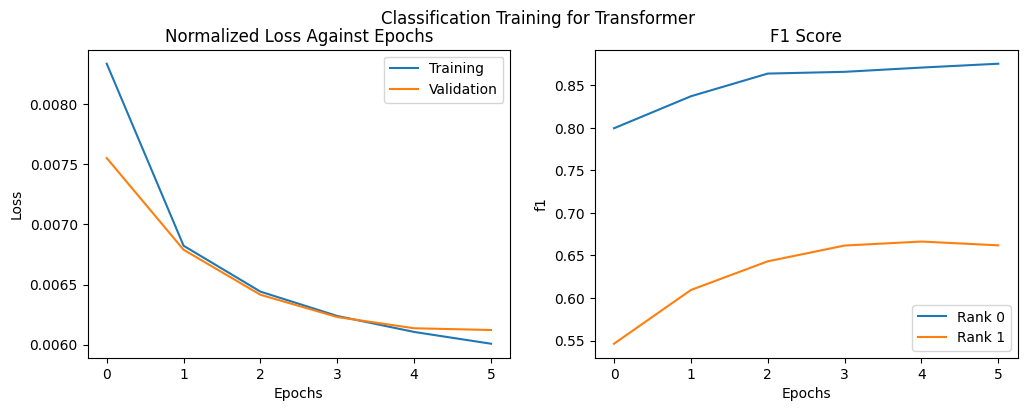

d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classe

Test results: [0.87955, 0.68935]


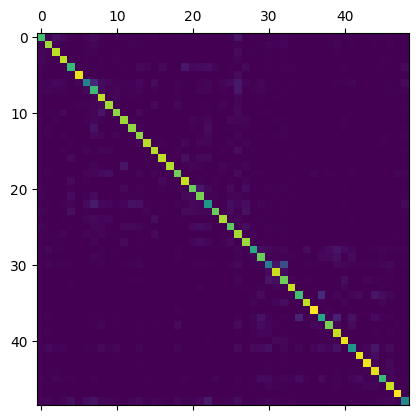

[[1344.   10.   80.   42.   22.    0.   23.   51.   21.    7.   16.   16.    8.    5.    1.   18.    2.    1.    7.    8.    4.   13.    5.    3.    5.   16.  107.    3.   18.    6.    7.    7.   28.   14.    1.    0.    0.    2.    7.   12.    3.   10.    7.    3.    9.   12.    2.    3.   11.]
 [   2. 1639.   22.   12.    2.    0.   10.   24.    9.    4.    7.    3.   18.   13.    1.    2.    0.    0.    6.    0.    0.    1.    2.    0.    1.    3.   16.    0.    7.   11.   29.   17.   28.    1.    1.    0.    4.    4.    9.   35.    2.   11.    2.    2.   10.    3.   17.    6.    4.]
 [  37.   20. 1722.   14.    0.    1.    8.   22.    6.    2.    9.    7.    1.    2.    0.    2.    0.    0.    1.    0.    1.    2.    1.    1.    0.    4.   45.    2.   10.    6.   14.    5.    9.    0.    0.    0.    0.    0.    3.   11.    2.    5.    2.    0.    7.    3.    3.    5.    5.]
 [  37.   10.   11. 1733.    0.    4.   10.    7.   21.    3.   20.    1.    6.    8.    4.   10.    0.    0.

In [9]:
from torch import arange, randn_like
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder, Sequential, LeakyReLU, Sigmoid,
                      ConvTranspose1d)


class Unsqueeze(Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x.unsqueeze(self.dim)


def add_gaussian_noise(x, std=0.1):
    noise = randn_like(x) * std
    return x + noise


class T_DAE_hybrid_1(Module):
    def __init__(self, N, M):
        super(T_DAE_hybrid_1, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=4,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=4)
        self.classifier = Linear(embed_dim, M)
        self.decoder = Sequential(
            Linear(embed_dim, N),
            LeakyReLU(),
            Linear(N, N * 4),
            LeakyReLU(),
            Unsqueeze(1),
            ConvTranspose1d(1, 4, kernel_size=3, stride=1, padding=1),
            LeakyReLU(),
            Sigmoid(),
        )

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        classification = self.classifier(x)
        if self.training:
            x = add_gaussian_noise(x, 0.1)
        reconstruction = self.decoder(x)
        return classification, reconstruction


model = benchmark(
    autoencoder.Classifier(LENGTH // 4, mapping, "cuda", T_DAE_hybrid_1, format.to_tetramers),
    "Transformer",
    max_epochs=6
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)


## 3. Multi-Level Classification

In [2]:
BERTAX_TRAIN = BERTAX_DIRECTORY + "train/"
BERTAX_VALIDATION = BERTAX_DIRECTORY + "validation/"
BERTAX_TEST = BERTAX_DIRECTORY + "test/"

from time import time
import json
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn

from stelaro import models
from stelaro.models import autoencoder, feedforward, transformer

LENGTH = 1500
BATCH_SIZE = 64

with open(BERTAX_DIRECTORY + "statistics/map.json", "r") as f:
    mapping = json.load(f)


train_data = DataLoader(
    models.SyntheticMultiLevelTetramerDataset(
        BERTAX_TRAIN,
        mapping,
        (),
        1,
        balance = True,
        other_factor = 0
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)
validation_data = DataLoader(
    models.SyntheticMultiLevelTetramerDataset(
        BERTAX_VALIDATION,
        mapping,
        (),
        1,
        balance = False,
        other_factor = 0
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data = DataLoader(
    models.SyntheticMultiLevelTetramerDataset(
        BERTAX_TEST,
        mapping,
        (),
        1,
        balance = False,
        other_factor = 0
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)
mapping = train_data.dataset.mapping


def benchmark(
        classifier: models.Classifier,
        name: str,
        max_epochs: int = 20
    ):
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1, validation_losses = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=max_epochs,
        patience=3,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised"
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="Training")
        ax[0].plot(x, validation_losses, label="Validation")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Normalized Loss Against Epochs")
        ax[0].legend()
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test F1 score: {rounded_result}")

    result = models.evaluate_precision(classifier, test_data, "cuda", mapping)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test precision score: {rounded_result}")

    return classifier

### 3.1. Domain-Level Predictions

100%|██████████| 34408/34408 [00:09<00:00, 3450.03it/s]


Training took 9.975 s.
Test F1 score: [0.19951]
Test precision score: [0.21396]


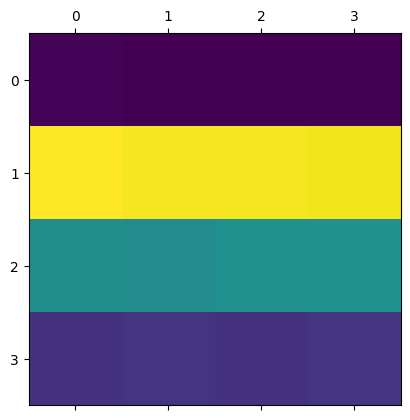

[[ 2057.  2001.  1967.  1975.]
 [12123. 11977. 12003. 11897.]
 [ 6984.  6879.  7050.  7087.]
 [ 3454.  3538.  3443.  3565.]]


In [3]:
model = benchmark(
    models.RandomClassifier(),
    "Random Classifier",
)
model.n_classes = len(mapping)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

In [11]:
from torch import arange
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)
from torch.optim import Adam


class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 256
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=4,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=4)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, format.to_tetramers),
    "Transformer",
    max_epochs=6
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Number of parameters: 3_321_604


100%|██████████| 34408/34408 [1:08:20<00:00,  8.39it/s]   


1/6 T loss: 0.04012. V loss: 0.03944. F1: [0.15438]. Patience: 3


100%|██████████| 34408/34408 [59:41<00:00,  9.61it/s]   


2/6 T loss: 0.04010. V loss: 0.03952. F1: [0.15444]. Patience: 3


 11%|█▏        | 3872/34408 [06:22<50:19, 10.11it/s]


KeyboardInterrupt: 

In [7]:
from torch.optim import Adam
import torch
from torch import nn

class T2Tokens(nn.Module):
    def __init__(self, N: int, M: int,
                 embed_dim: int = 256,
                 vocab_size: int = 256,
                 nhead: int = 4,
                 num_layers: int = 4,
                 dropout: float = 0.0
                 ):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_seq_len = N
        self.embed_dim = embed_dim
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(N + 1, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.normal_(self.cls_token, mean=0.0, std=0.02)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation="relu",
            batch_first=True,  # [B, L, D]
            norm_first=False,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.pre_classifier_norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Linear(embed_dim, M)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L = x.shape
        tok = self.token_embedding(x)  # [B, L, D]
        cls = self.cls_token.expand(B, 1, self.embed_dim)  # [B, 1, D]
        h = torch.cat([cls, tok], dim=1)  # [B, L+1, D]
        pos_idx = torch.arange(L + 1, device=x.device)            # [L+1]
        pos = self.position_embedding(pos_idx).unsqueeze(0)       # [1, L+1, D]
        h = h + pos                                               # [B, L+1, D]
        h = self.transformer_encoder(h, mask=None)  # [B, L+1, D]
        cls_out = h[:, 0, :]  # [B, D]
        cls_out = self.pre_classifier_norm(cls_out)
        logits = self.classifier(cls_out)  # [B, M]
        return logits


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", T2Tokens, format.to_tetramers),
    "Transformer",
    max_epochs=6
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Number of parameters: 3_322_628


100%|██████████| 34408/34408 [53:11<00:00, 10.78it/s]   


1/6 T loss: 14.74865. V loss: 14.51099. F1: [0.15434]. P: [0.11298] Patience: 3


100%|██████████| 34408/34408 [1:53:11<00:00,  5.07it/s]     


2/6 T loss: 14.73758. V loss: 14.44126. F1: [0.15435]. P: [0.11297] Patience: 3


  4%|▍         | 1490/34408 [02:17<50:48, 10.80it/s]


KeyboardInterrupt: 

Number of parameters: 477_828


100%|██████████| 8602/8602 [20:09<00:00,  7.11it/s]


1/6 T loss: 0.00616. V loss: 0.00541. F1: [0.77393]. Patience: 3


100%|██████████| 8602/8602 [20:16<00:00,  7.07it/s]


2/6 T loss: 0.00518. V loss: 0.00496. F1: [0.81439]. Patience: 3


100%|██████████| 8602/8602 [20:10<00:00,  7.11it/s]


3/6 T loss: 0.00485. V loss: 0.00466. F1: [0.83903]. Patience: 3


100%|██████████| 8602/8602 [20:09<00:00,  7.11it/s]


4/6 T loss: 0.00466. V loss: 0.00451. F1: [0.85066]. Patience: 3


100%|██████████| 8602/8602 [20:19<00:00,  7.06it/s]


5/6 T loss: 0.00452. V loss: 0.00439. F1: [0.86507]. Patience: 3


100%|██████████| 8602/8602 [20:11<00:00,  7.10it/s]


6/6 T loss: 0.00443. V loss: 0.00438. F1: [0.86275]. Patience: 2
Training took 7508.566 s.


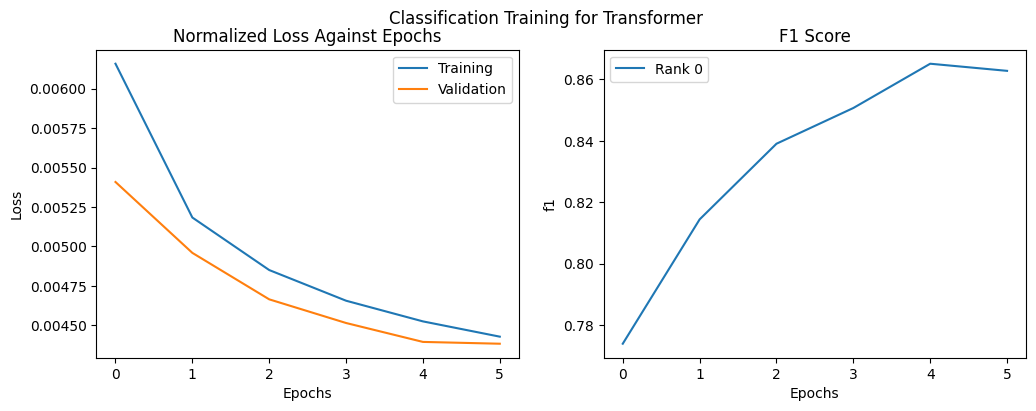

Test results: [0.86615]


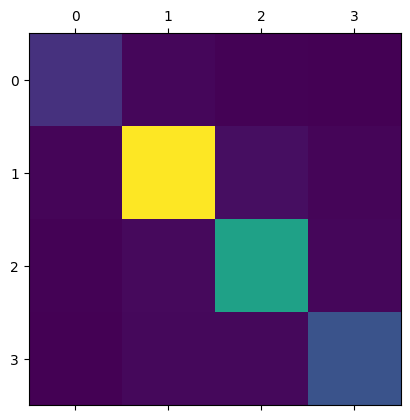

[[ 6437.   896.   493.   174.]
 [  830. 44473.  1885.   812.]
 [  359.  1229. 25514.   898.]
 [  210.  1163.  1101. 11526.]]


In [5]:
class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, format.to_tetramers),
    "Transformer",
    max_epochs=6
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

### 3.2. BERT

In [10]:
import torch
from torch import nn
import torch.nn.functional as F


class BERT(nn.Module):
    """
    Encoder-only transformer with:
      - Classification head (using [CLS] token)
      - Masked Language Modeling (MLM) head
    """
    def __init__(self, N: int, M: int,
                 embed_dim: int = 64,
                 vocab_size: int = 256,
                 nhead: int = 4,
                 num_layers: int = 12,
                 dropout: float = 0.0):
        super().__init__()
        self.vocab_size = vocab_size + 1   # add one for [MASK]
        self.mask_id = vocab_size          # reserved id for [MASK]
        self.max_seq_len = N
        self.embed_dim = embed_dim

        # Token + positional embeddings
        self.token_embedding = nn.Embedding(self.vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(N + 1, embed_dim)

        # Learnable [CLS] token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.normal_(self.cls_token, mean=0.0, std=0.02)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation="relu",
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        # Heads
        self.classifier = nn.Linear(embed_dim, M)         # classification head
        self.mlm_head = nn.Linear(embed_dim, self.vocab_size)  # MLM head

    def forward(self, x, mlm_labels=None):
        """
        x: [B, L] token ids (with [MASK] tokens possibly inserted)
        mlm_labels: [B, L] original token ids, or -100 for non-masked tokens
        """
        B, L = x.shape

        # Embeddings
        tok = self.token_embedding(x)                  # [B, L, D]
        cls = self.cls_token.expand(B, 1, self.embed_dim)  # [B, 1, D]
        h = torch.cat([cls, tok], dim=1)               # [B, L+1, D]

        # Add positions
        pos = self.position_embedding(
            torch.arange(L + 1, device=x.device).unsqueeze(0)
        )                                              # [1, L+1, D]
        h = h + pos

        # Encode
        h = self.transformer_encoder(h)                # [B, L+1, D]

        # Classification head
        cls_out = h[:, 0, :]                           # [B, D]
        logits_cls = self.classifier(cls_out)          # [B, M]

        # MLM head (skip CLS token)
        tok_out = h[:, 1:, :]                          # [B, L, D]
        logits_mlm = self.mlm_head(tok_out)            # [B, L, vocab_size]

        if mlm_labels is not None:
            return logits_cls, logits_mlm
        else:
            return logits_cls


def mask_tokens(x, mask_id, vocab_size, mlm_probability=0.15):
    """
    Prepare masked input and MLM labels for MLM pretraining.
    x: [B, L] input tensor (long)
    Returns:
      masked_x: [B, L]
      mlm_labels: [B, L] (original ids, or -100 for unmasked positions)

    TODO: Implement NSP in addition to MLM
    """
    labels = x.clone()
    probability_matrix = torch.full(labels.shape, mlm_probability, device=x.device)
    mask = torch.bernoulli(probability_matrix).bool()

    mlm_labels = labels.clone()
    mlm_labels[~mask] = -100  # only compute loss on masked tokens

    # 80 %: [MASK]
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8, device=x.device)).bool() & mask
    x[indices_replaced] = mask_id

    # 10 %: random token
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5, device=x.device)).bool() & mask & ~indices_replaced
    random_tokens = torch.randint(0, vocab_size, labels.shape, dtype=torch.long, device=x.device)
    x[indices_random] = random_tokens[indices_random]

    # 10 %: unchanged (mask stays same)
    return x, mlm_labels


import torch
from torch import optim
from tqdm import tqdm

def pretrain_mlm(model, dataloader, formatter, num_epochs=5, lr=1e-4, device="cuda"):
    """
    Pretrain the encoder-only model with Masked Language Modeling (MLM).

    Args:
        model: T2Tokens instance
        dataloader: yields batches of [B, L] token ids (0..255)
        num_epochs: number of training epochs
        lr: learning rate
        device: "cuda" or "cpu"
    """
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    last_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        total_loss, num_batches = 0.0, 0

        for x_batch, _ in tqdm(dataloader):
            x_batch = x_batch.long().to(device)
            x_batch = formatter(x_batch)

            # Mask tokens
            masked_x, mlm_labels = mask_tokens(
                x_batch.clone(), model.mask_id, vocab_size=256
            )

            # Forward pass
            _, logits_mlm = model(masked_x, mlm_labels=mlm_labels)

            # MLM loss only
            loss = torch.nn.functional.cross_entropy(
                logits_mlm.view(-1, model.vocab_size),
                mlm_labels.view(-1),
                ignore_index=-100,
            )

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
            if num_batches > 1000:
                break

        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}: MLM loss = {avg_loss:.4f}")
        if avg_loss > last_loss:
            print("Overfitting; stopping early")
        else:
            last_loss = avg_loss


In [7]:
from torch.optim import Adam

classifier = models.Classifier(LENGTH // 4, mapping, "cuda", BERT, format.to_tetramers)

print("Pretraining")
pretrain_mlm(classifier.model, train_data, format.to_tetramers)

print("Fine-tuning:")
model = benchmark(
    classifier,
    "Transformer",
    max_epochs=5
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Pretraining


  3%|▎         | 300/8602 [01:12<33:27,  4.14it/s]


Epoch 1: MLM loss = 5.4689


  3%|▎         | 300/8602 [01:14<34:13,  4.04it/s]


Epoch 2: MLM loss = 5.3149


  3%|▎         | 300/8602 [01:15<34:37,  4.00it/s]


Epoch 3: MLM loss = 5.2365


  3%|▎         | 300/8602 [01:15<34:45,  3.98it/s]


Epoch 4: MLM loss = 5.1705


  3%|▎         | 300/8602 [01:15<34:42,  3.99it/s]


Epoch 5: MLM loss = 5.1173
Fine-tuning:
Number of parameters: 457_413


  2%|▏         | 201/8602 [01:24<25:19:14, 10.85s/it]

P: [0.31482]


  5%|▍         | 401/8602 [02:49<24:54:01, 10.93s/it]

P: [0.32307]


  7%|▋         | 601/8602 [04:15<24:16:13, 10.92s/it]

P: [0.49682]


  9%|▉         | 801/8602 [05:40<23:42:04, 10.94s/it]

P: [0.62916]


 12%|█▏        | 1001/8602 [07:05<22:54:34, 10.85s/it]

P: [0.65748]


 14%|█▍        | 1201/8602 [08:30<22:21:49, 10.88s/it]

P: [0.65756]


 16%|█▋        | 1401/8602 [09:55<21:44:35, 10.87s/it]

P: [0.65446]


 19%|█▊        | 1601/8602 [11:20<21:16:05, 10.94s/it]

P: [0.68484]


 21%|██        | 1801/8602 [12:45<20:35:49, 10.90s/it]

P: [0.69552]


 23%|██▎       | 2001/8602 [14:10<20:06:41, 10.97s/it]

P: [0.72442]


 23%|██▎       | 2009/8602 [14:13<46:39,  2.36it/s]   


KeyboardInterrupt: 

In [11]:
from torch.optim import Adam

classifier = models.Classifier(LENGTH // 4, mapping, "cuda", BERT, format.to_tetramers)

print("Pretraining")
pretrain_mlm(classifier.model, train_data, format.to_tetramers)

print("Fine-tuning:")
model = benchmark(
    classifier,
    "Transformer",
    max_epochs=5
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Pretraining


 12%|█▏        | 1000/8602 [06:10<46:58,  2.70it/s]


Epoch 1: MLM loss = 5.3338


 12%|█▏        | 1000/8602 [06:16<47:42,  2.66it/s]


Epoch 2: MLM loss = 5.1097


 12%|█▏        | 1000/8602 [06:13<47:16,  2.68it/s]


Epoch 3: MLM loss = 5.0167


 12%|█▏        | 1000/8602 [06:13<47:21,  2.68it/s]


Epoch 4: MLM loss = 4.9881


 12%|█▏        | 1000/8602 [06:11<47:03,  2.69it/s]


Epoch 5: MLM loss = 4.9764
Fine-tuning:
Number of parameters: 657_349


  2%|▏         | 201/8602 [02:05<37:30:22, 16.07s/it]

P: [0.11299]


  5%|▍         | 401/8602 [04:10<36:35:57, 16.07s/it]

P: [0.22682]


  7%|▋         | 601/8602 [06:15<35:33:58, 16.00s/it]

P: [0.11298]


  9%|▉         | 801/8602 [08:19<34:26:27, 15.89s/it]

P: [0.11299]


 12%|█▏        | 1001/8602 [10:24<34:04:43, 16.14s/it]

P: [0.11298]


 12%|█▏        | 1021/8602 [10:32<1:18:18,  1.61it/s] 


KeyboardInterrupt: 

Number of parameters: 1_808_901


100%|██████████| 34408/34408 [28:23<00:00, 20.20it/s]


1/6 T loss: 5.86776. V loss: 4.58162. F1: [0.79918]. P: [0.82177] Patience: 3


100%|██████████| 34408/34408 [29:20<00:00, 19.54it/s]


2/6 T loss: 4.66139. V loss: 4.33302. F1: [0.81639]. P: [0.82271] Patience: 3


100%|██████████| 34408/34408 [28:38<00:00, 20.02it/s]


3/6 T loss: 4.33094. V loss: 4.17338. F1: [0.82328]. P: [0.82949] Patience: 3


100%|██████████| 34408/34408 [7:33:17<00:00,  1.27it/s]        


4/6 T loss: 4.12279. V loss: 4.14065. F1: [0.81938]. P: [0.85234] Patience: 2


100%|██████████| 34408/34408 [28:11<00:00, 20.34it/s]


5/6 T loss: 3.99286. V loss: 3.83138. F1: [0.83643]. P: [0.84451] Patience: 2


100%|██████████| 34408/34408 [28:12<00:00, 20.32it/s]


6/6 T loss: 3.88258. V loss: 3.75313. F1: [0.83823]. P: [0.85849] Patience: 2
Training took 36296.488 s.


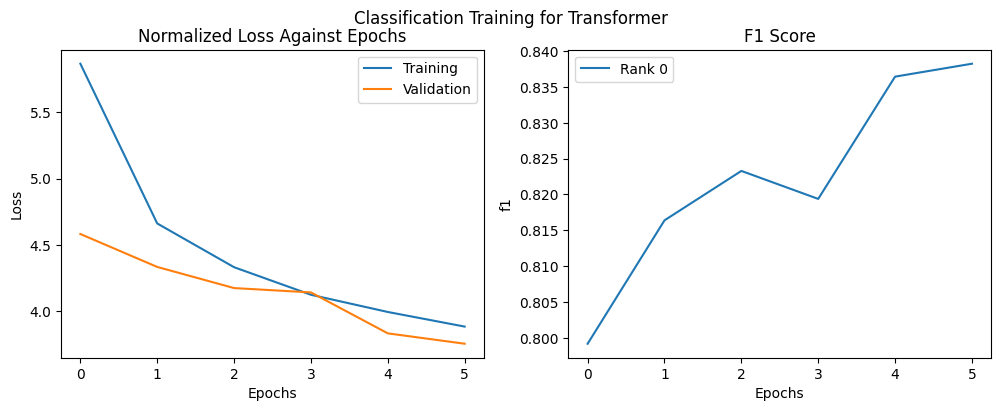

Test F1 score: [0.838]
Test precision score: [0.85377]


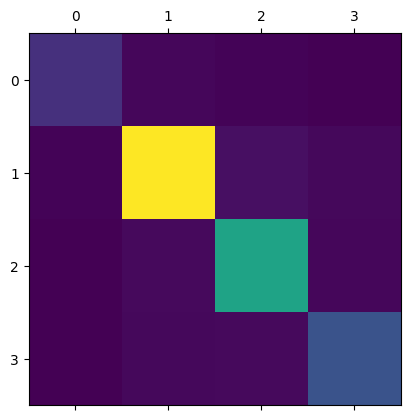

[[ 6251.   984.   564.   201.]
 [  662. 44174.  2027.  1137.]
 [  197.  1298. 25630.   875.]
 [  161.  1137.  1205. 11497.]]


In [ ]:
from torch.optim import Adam

model = benchmark(
    classifier,
    "Transformer",
    max_epochs=6
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

### 3.3. CNN-BERT

In [37]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d)


class DNACompressor(nn.Module):
    def __init__(self, embed_dim: int, L_prime: int):
        """
        embed_dim: final embedding dimension D
        L_prime: desired compressed sequence length L'
        """
        super().__init__()
        # Convolutional layers to extract local features
        self.conv = nn.Sequential(
            nn.Conv1d(4, 64, kernel_size=7, stride=2, padding=3),  # [B, 64, L/2]
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2), # [B, 128, L/4]
            nn.ReLU(),
        )
        self.linear = nn.Linear(128, embed_dim)
        self.L_prime = L_prime

    def forward(self, x):
        """
        x: [B, 4, L]
        returns: [B, L', D]
        """
        x = self.conv(x)               # [B, 128, L/4]
        x = x.transpose(1, 2)          # [B, L/4, 128] -> sequence first
        x = self.linear(x)             # [B, L/4, D]
        x = x.transpose(1, 2)          # [B, D, L/4]
        x = F.interpolate(x, size=self.L_prime, mode='linear', align_corners=False)
        x = x.transpose(1, 2)          # [B, L', D]
        return x


class CNN_BERT(nn.Module):
    def __init__(self, N: int, M: int,
                 embed_dim: int = 128,
                 nhead: int = 4,
                 num_layers: int = 4,
                 dropout: float = 0.05
                 ):
        super().__init__()
        self.embed_dim = embed_dim
        self.cnn_encoder = DNACompressor(embed_dim, embed_dim)
        self.vocab_size = 4
        self.mask_id = 4
        self.position_embedding = nn.Embedding(embed_dim + 1, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.normal_(self.cls_token, mean=0.0, std=0.02)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation="relu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.classifier = nn.Linear(embed_dim, M)
        self.condenser = nn.Linear(embed_dim, 4)
        self.mlm_head = nn.Linear(embed_dim, N)

    def forward(self, x, mlm_labels=None):
        B, C, L = x.shape  # Batch size, n_channels, sequence length
        tok = self.cnn_encoder(x)  # [B, D, D]  D: embedding size
        cls = self.cls_token.expand(B, 1, self.embed_dim)  # [B, 1, D]
        pos = self.position_embedding(
            torch.arange(self.embed_dim + 1, device=x.device).unsqueeze(0)
        )  # [1, D+1, D]
        h = torch.cat([cls, tok], dim=1)  # [B, D+1, D]
        h = h + pos

        # Encode
        h = self.transformer(h)  # [B, L+1, D]

        # Classification head
        cls_out = h[:, 0, :]  # [B, D]
        logits_cls = self.classifier(cls_out)  # [B, M]

        if mlm_labels is not None:
            tok_out = h[:, 1:, :]  # [B, D, D]
            logits_mlm = self.condenser(tok_out)  # [B, D, 4]
            logits_mlm = logits_mlm.transpose(1, 2)  # [B, 4, D]
            logits_mlm = self.mlm_head(logits_mlm)  # [B, 4, L]
            return logits_cls, logits_mlm
        else:
            return logits_cls


def mask_tokens(x, mask_id, vocab_size, mlm_probability=0.15):
    """
    Prepare masked input and MLM labels for MLM pretraining.
    x: [B, L] input tensor (long)
    Returns:
      masked_x: [B, L]
      mlm_labels: [B, L] (original ids, or -100 for unmasked positions)
    """
    labels = x.clone()
    probability_matrix = torch.full(labels.shape, mlm_probability, device=x.device)
    mask = torch.bernoulli(probability_matrix).bool()

    mlm_labels = labels.clone()
    mlm_labels[~mask] = -100  # only compute loss on masked tokens

    # 80 %: [MASK]
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8, device=x.device)).bool() & mask
    x[indices_replaced] = mask_id

    # 10 %: random token
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5, device=x.device)).bool() & mask & ~indices_replaced
    random_tokens = torch.rand(labels.shape, dtype=torch.float, device=x.device)
    x[indices_random] = random_tokens[indices_random]

    # 10 %: unchanged (mask stays same)
    return x, mlm_labels


import torch
from torch import optim
from tqdm import tqdm

def pretrain_mlm(model, dataloader, formatter, num_epochs=5, lr=1e-4, device="cuda"):
    """
    Pretrain the encoder-only model with Masked Language Modeling (MLM).

    Args:
        model: T2Tokens instance
        dataloader: yields batches of [B, L] token ids (0..255)
        num_epochs: number of training epochs
        lr: learning rate
        device: "cuda" or "cpu"
    """
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    last_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        total_loss, num_batches = 0.0, 0

        for x_batch, _ in tqdm(dataloader):
            x_batch = x_batch.long().to(device)
            x_batch = formatter(x_batch)

            # Mask tokens
            # masked_x, mlm_labels = mask_tokens(
            #     x_batch.clone(), model.mask_id, vocab_size=model.vocab_size
            # )

            # Forward pass
            # _, logits_mlm = model(masked_x, mlm_labels=mlm_labels)
            _, logits_mlm = model(x_batch, mlm_labels=True)

            # MLM loss only
            loss = torch.nn.functional.cross_entropy(
                logits_mlm, x_batch
            )

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1
            if num_batches > 3_000:
                break

        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}: MLM loss = {avg_loss:.4f}")
        if avg_loss > last_loss:
            print("Overfitting; stopping early")
        else:
            last_loss = avg_loss


In [38]:
from torch.optim import Adam
from stelaro.models import Classifier

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

classifier = Classifier(LENGTH, mapping, "cuda", CNN_BERT, format.to_channels)

print("Pretraining.")
pretrain_mlm(classifier.model, train_data, format.to_channels)

print("Fine-tuning:")
model = benchmark(
    classifier,
    "Transformer",
    max_epochs=5
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Pretraining.


 17%|█▋        | 3000/17204 [02:48<13:19, 17.77it/s]


Epoch 1: MLM loss = 1.3439


 17%|█▋        | 3000/17204 [02:50<13:28, 17.57it/s]


Epoch 2: MLM loss = 1.2582


 17%|█▋        | 3000/17204 [02:51<13:33, 17.47it/s]


Epoch 3: MLM loss = 1.1866


 17%|█▋        | 3000/17204 [02:51<13:31, 17.51it/s]


Epoch 4: MLM loss = 1.1760


 17%|█▋        | 3000/17204 [02:51<13:33, 17.45it/s]


Epoch 5: MLM loss = 1.1562
Fine-tuning:
Number of parameters: 1_063_716


100%|██████████| 17204/17204 [15:53<00:00, 18.03it/s]


1/5 T loss: 29.41804. V loss: 28.95389. F1: [0.15499]. P: [0.11298] Patience: 3


  0%|          | 82/17204 [00:04<15:50, 18.01it/s]


KeyboardInterrupt: 

### 3.4. Autoencoder + Attention

In [16]:
import torch
from torch import arange
from torch import optim
from tqdm import tqdm
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, MSELoss, MaxPool1d, ConvTranspose1d,
                      Sigmoid, LeakyReLU)
from torch.nn import (Module, Linear, Embedding, TransformerEncoderLayer,
                      TransformerEncoder)
import torch.nn as nn


def add_masking_noise(x, dropout_prob=0.1):
    mask = torch.bernoulli((1 - dropout_prob) * torch.ones_like(x))
    return x * mask


class Unsqueeze(Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x.unsqueeze(self.dim)


class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 256
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=4,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=4)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits



class DAE_1(Module):
    """Denoising autoencoder 1."""
    def __init__(self, N, M):
        super(DAE_1, self).__init__()
        LATENT_SPACE_SIZE = 128
        self.encoder = Sequential(
            Conv1d(4, 32, kernel_size=5, padding=2),
            LeakyReLU(),
            MaxPool1d(kernel_size=2),
            Conv1d(32, 64, kernel_size=3, padding=1),
            LeakyReLU(),
            Flatten(),
            Linear(N * 64 // 2, N // 2),
            LeakyReLU(),
            Linear(N // 2, LATENT_SPACE_SIZE),
            LeakyReLU(),
        )
        self.decoder = Sequential(
            Linear(LATENT_SPACE_SIZE, N // 2),
            LeakyReLU(),
            Linear(N // 2, N),
            LeakyReLU(),
            Unsqueeze(1),
            ConvTranspose1d(1, 4, kernel_size=3, stride=1, padding=1),
            LeakyReLU(),
            Sigmoid(),
        )
        self.decoder = Sequential(
            Linear(LATENT_SPACE_SIZE, M),
        )

        embed_dim = 256
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=4,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=4)
        self.classifier = Linear(embed_dim, M)

        self.alpha = nn.Parameter(torch.tensor(0.5))

    def forward(self, x, pretraining: bool = False):
        # CNN
        latent = self.encoder(format.to_channels(x))
        classification = self.decoder(latent)
        return classification

        # Transformer
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        classification_tm = self.classifier(x)  # [B, num_classes]

        classification = self.alpha * classification_cnn + (1 - self.alpha) * classification_tm


def pretrain_mlm(model, dataloader, formatter, num_epochs=5, lr=1e-4, device="cuda"):
    """
    Pretrain the encoder-only model with Masked Language Modeling (MLM).

    Args:
        model: T2Tokens instance
        dataloader: yields batches of [B, L] token ids (0..255)
        num_epochs: number of training epochs
        lr: learning rate
        device: "cuda" or "cpu"
    """
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    last_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        total_loss, num_batches = 0.0, 0

        for x_batch, _ in tqdm(dataloader):
            x_batch = x_batch.long().to(device)
            x_batch = formatter(x_batch)
            _, reconstruction = model(x_batch, True)
            loss = torch.nn.functional.cross_entropy(
                reconstruction, x_batch
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
            if num_batches > 500:
                break

        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}: MLM loss = {avg_loss:.4f}")
        if avg_loss > last_loss:
            print("Overfitting; stopping early")
        else:
            last_loss = avg_loss

In [17]:
from torch.optim import Adam

classifier = models.Classifier(LENGTH, mapping, "cuda", DAE_1, format.to_tetramers)

print("Fine-tuning:")
model = benchmark(
    classifier,
    "Transformer",
    max_epochs=10
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Fine-tuning:
Number of parameters: 39_713_879


  1%|          | 206/17204 [00:07<58:49,  4.82it/s]

P: [0.24264]


  2%|▏         | 409/17204 [00:15<42:46,  6.54it/s]

P: [0.30032]


  4%|▎         | 611/17204 [00:23<48:14,  5.73it/s]  

P: [0.53006]


  5%|▍         | 809/17204 [00:32<47:04,  5.80it/s]  

P: [0.59883]


  6%|▌         | 1010/17204 [00:39<43:40,  6.18it/s]  

P: [0.61826]


  7%|▋         | 1208/17204 [00:48<45:05,  5.91it/s]  

P: [0.65572]


  8%|▊         | 1411/17204 [00:55<42:46,  6.15it/s]

P: [0.65565]


  9%|▉         | 1607/17204 [01:03<56:44,  4.58it/s]

P: [0.70749]


 11%|█         | 1812/17204 [01:11<41:14,  6.22it/s]

P: [0.67326]


 12%|█▏        | 2008/17204 [01:19<39:38,  6.39it/s]

P: [0.70032]


 13%|█▎        | 2211/17204 [01:26<39:48,  6.28it/s]

P: [0.69325]


 14%|█▍        | 2407/17204 [01:34<56:38,  4.35it/s]

P: [0.6955]


 15%|█▌        | 2613/17204 [01:42<39:32,  6.15it/s]

P: [0.70087]


 16%|█▋        | 2808/17204 [01:50<38:04,  6.30it/s]

P: [0.70592]


 17%|█▋        | 3008/17204 [01:58<39:07,  6.05it/s]

P: [0.75518]


 19%|█▊        | 3207/17204 [02:06<52:06,  4.48it/s]

P: [0.71919]


 20%|█▉        | 3412/17204 [02:14<39:31,  5.81it/s]

P: [0.72648]


 21%|██        | 3608/17204 [02:22<37:52,  5.98it/s]

P: [0.77084]


 22%|██▏       | 3806/17204 [02:30<51:46,  4.31it/s]

P: [0.77433]


 23%|██▎       | 4009/17204 [02:39<38:12,  5.75it/s]

P: [0.75253]


 24%|██▍       | 4211/17204 [02:47<35:58,  6.02it/s]

P: [0.747]


 26%|██▌       | 4409/17204 [02:54<34:12,  6.23it/s]

P: [0.7654]


 27%|██▋       | 4609/17204 [03:02<33:02,  6.35it/s]

P: [0.78369]


 28%|██▊       | 4808/17204 [03:10<33:31,  6.16it/s]

P: [0.7028]


 29%|██▉       | 5012/17204 [03:18<31:46,  6.39it/s]

P: [0.76379]


 30%|███       | 5209/17204 [03:26<31:55,  6.26it/s]

P: [0.77566]


 31%|███▏      | 5409/17204 [03:33<30:17,  6.49it/s]

P: [0.76454]


 33%|███▎      | 5609/17204 [03:41<29:56,  6.45it/s]

P: [0.79452]


 34%|███▍      | 5812/17204 [03:49<30:41,  6.19it/s]

P: [0.79332]


 35%|███▍      | 6010/17204 [03:57<29:23,  6.35it/s]

P: [0.78325]


 36%|███▌      | 6207/17204 [04:05<40:13,  4.56it/s]

P: [0.7665]


 37%|███▋      | 6407/17204 [04:12<39:24,  4.57it/s]

P: [0.77527]


 38%|███▊      | 6612/17204 [04:20<27:40,  6.38it/s]

P: [0.76514]


 40%|███▉      | 6811/17204 [04:28<26:30,  6.53it/s]

P: [0.75632]


 41%|████      | 7010/17204 [04:35<25:08,  6.76it/s]

P: [0.77159]


 42%|████▏     | 7209/17204 [04:43<26:04,  6.39it/s]

P: [0.78092]


 43%|████▎     | 7407/17204 [04:51<34:06,  4.79it/s]

P: [0.79055]


 44%|████▍     | 7610/17204 [04:59<26:19,  6.07it/s]

P: [0.76234]


 45%|████▌     | 7812/17204 [05:07<25:50,  6.06it/s]

P: [0.78753]


 47%|████▋     | 8005/17204 [05:14<32:15,  4.75it/s]

P: [0.80056]


 48%|████▊     | 8211/17204 [05:22<24:26,  6.13it/s]

P: [0.77797]


 49%|████▉     | 8412/17204 [05:30<23:04,  6.35it/s]

P: [0.79831]


 50%|█████     | 8612/17204 [05:38<24:01,  5.96it/s]

P: [0.79348]


 51%|█████     | 8807/17204 [05:46<30:32,  4.58it/s]

P: [0.77444]


 52%|█████▏    | 9009/17204 [05:54<20:55,  6.53it/s]

P: [0.82702]


 54%|█████▎    | 9212/17204 [06:01<20:39,  6.45it/s]

P: [0.80379]


 55%|█████▍    | 9410/17204 [06:09<20:15,  6.41it/s]

P: [0.8107]


 56%|█████▌    | 9608/17204 [06:17<19:41,  6.43it/s]

P: [0.81157]


 57%|█████▋    | 9808/17204 [06:24<19:15,  6.40it/s]

P: [0.76852]


 58%|█████▊    | 10011/17204 [06:32<19:43,  6.08it/s]

P: [0.79687]


 59%|█████▉    | 10208/17204 [06:40<18:55,  6.16it/s]

P: [0.81738]


 60%|██████    | 10406/17204 [06:48<24:32,  4.62it/s]

P: [0.77935]


 62%|██████▏   | 10606/17204 [06:56<23:12,  4.74it/s]

P: [0.81741]


 63%|██████▎   | 10807/17204 [07:04<23:23,  4.56it/s]

P: [0.80984]


 64%|██████▍   | 11010/17204 [07:12<17:23,  5.93it/s]

P: [0.80177]


 65%|██████▌   | 11207/17204 [07:20<22:27,  4.45it/s]

P: [0.811]


 66%|██████▋   | 11413/17204 [07:28<15:56,  6.05it/s]

P: [0.78729]


 67%|██████▋   | 11609/17204 [07:36<16:38,  5.60it/s]

P: [0.82122]


 69%|██████▊   | 11808/17204 [07:44<13:51,  6.49it/s]

P: [0.81931]


 70%|██████▉   | 12010/17204 [07:51<12:03,  7.18it/s]

P: [0.78689]


 71%|███████   | 12207/17204 [07:59<17:20,  4.80it/s]

P: [0.82844]


 72%|███████▏  | 12412/17204 [08:07<13:28,  5.93it/s]

P: [0.81677]


 73%|███████▎  | 12609/17204 [08:15<12:42,  6.02it/s]

P: [0.79682]


 74%|███████▍  | 12806/17204 [08:22<16:06,  4.55it/s]

P: [0.8144]


 76%|███████▌  | 13011/17204 [08:30<10:48,  6.47it/s]

P: [0.82906]


 77%|███████▋  | 13209/17204 [08:38<10:33,  6.31it/s]

P: [0.8347]


 78%|███████▊  | 13407/17204 [08:46<13:35,  4.66it/s]

P: [0.79106]


 79%|███████▉  | 13612/17204 [08:54<10:02,  5.97it/s]

P: [0.78993]


 80%|████████  | 13808/17204 [09:02<09:16,  6.10it/s]

P: [0.80729]


 81%|████████▏ | 14011/17204 [09:09<08:27,  6.30it/s]

P: [0.8383]


 83%|████████▎ | 14207/17204 [09:17<10:58,  4.55it/s]

P: [0.82162]


 84%|████████▍ | 14410/17204 [09:25<07:16,  6.39it/s]

P: [0.84101]


 85%|████████▍ | 14607/17204 [09:33<09:42,  4.46it/s]

P: [0.80168]


 86%|████████▌ | 14811/17204 [09:40<06:03,  6.58it/s]

P: [0.81835]


 87%|████████▋ | 15008/17204 [09:48<05:41,  6.44it/s]

P: [0.84637]


 88%|████████▊ | 15212/17204 [09:56<05:26,  6.09it/s]

P: [0.79495]


 90%|████████▉ | 15408/17204 [10:04<04:48,  6.22it/s]

P: [0.83273]


 91%|█████████ | 15612/17204 [10:12<04:17,  6.17it/s]

P: [0.84161]


 92%|█████████▏| 15812/17204 [10:19<03:31,  6.58it/s]

P: [0.84986]


 93%|█████████▎| 16009/17204 [10:27<02:59,  6.64it/s]

P: [0.82623]


 94%|█████████▍| 16207/17204 [10:34<03:36,  4.61it/s]

P: [0.81265]


 95%|█████████▌| 16411/17204 [10:42<02:04,  6.39it/s]

P: [0.82287]


 97%|█████████▋| 16609/17204 [10:50<01:36,  6.15it/s]

P: [0.81623]


 98%|█████████▊| 16809/17204 [10:58<01:04,  6.09it/s]

P: [0.8368]


 99%|█████████▉| 17009/17204 [11:06<00:30,  6.47it/s]

P: [0.83656]


100%|█████████▉| 17197/17204 [11:09<00:00, 68.48it/s]

P: [0.83452]


100%|██████████| 17204/17204 [11:16<00:00, 25.44it/s]


1/10 T loss: 12.94585. V loss: 9.31988. F1: [0.80226]. P: [0.83822] Patience: 3


  1%|          | 207/17204 [00:07<59:45,  4.74it/s]

P: [0.83418]


  2%|▏         | 410/17204 [00:15<42:14,  6.63it/s]

P: [0.83396]


  4%|▎         | 608/17204 [00:23<44:43,  6.18it/s]  

P: [0.82563]


  5%|▍         | 813/17204 [00:30<43:58,  6.21it/s]  

P: [0.79977]


  6%|▌         | 1011/17204 [00:38<45:20,  5.95it/s]  

P: [0.84001]


  7%|▋         | 1209/17204 [00:46<44:19,  6.01it/s]  

P: [0.79002]


  8%|▊         | 1412/17204 [00:55<44:08,  5.96it/s]  

P: [0.80491]


  9%|▉         | 1610/17204 [01:02<40:47,  6.37it/s]

P: [0.81552]


 11%|█         | 1813/17204 [01:10<42:16,  6.07it/s]

P: [0.80451]


 12%|█▏        | 2009/17204 [01:18<38:47,  6.53it/s]

P: [0.82278]


 13%|█▎        | 2208/17204 [01:26<40:28,  6.18it/s]

P: [0.83566]


 14%|█▍        | 2406/17204 [01:33<51:11,  4.82it/s]

P: [0.81655]


 15%|█▌        | 2612/17204 [01:41<38:15,  6.36it/s]

P: [0.82624]


 16%|█▋        | 2810/17204 [01:49<37:49,  6.34it/s]

P: [0.81111]


 17%|█▋        | 3006/17204 [01:56<49:58,  4.74it/s]

P: [0.85002]


 19%|█▊        | 3210/17204 [02:04<35:50,  6.51it/s]

P: [0.8219]


 20%|█▉        | 3410/17204 [02:11<35:00,  6.57it/s]

P: [0.84307]


 21%|██        | 3610/17204 [02:19<34:37,  6.54it/s]

P: [0.83821]


 22%|██▏       | 3810/17204 [02:26<34:09,  6.54it/s]

P: [0.82658]


 23%|██▎       | 4008/17204 [02:34<33:34,  6.55it/s]

P: [0.84899]


 24%|██▍       | 4206/17204 [02:41<45:28,  4.76it/s]

P: [0.8278]


 26%|██▌       | 4410/17204 [02:49<32:24,  6.58it/s]

P: [0.83977]


 27%|██▋       | 4608/17204 [02:57<33:23,  6.29it/s]

P: [0.80357]


 28%|██▊       | 4813/17204 [03:05<32:27,  6.36it/s]

P: [0.83599]


 29%|██▉       | 5000/17204 [03:11<07:46, 26.16it/s]


KeyboardInterrupt: 

### 3.5. Mamba

In [3]:
from torch.optim import Adam
import torch
from mambapy.mamba import Mamba, MambaConfig


class MAMBA(nn.Module):
    """
    Encoder-only transformer with:
      - Classification head (using [CLS] token)
      - Masked Language Modeling (MLM) head
    """
    def __init__(self, N: int, M: int,
                 embed_dim: int = 128,
                 vocab_size: int = 256,
                 num_layers: int = 2,
                 ):
        super().__init__()
        config = MambaConfig(d_model=embed_dim, n_layers=num_layers)
        self.network = Mamba(config)
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.classifier = nn.Linear(embed_dim, M)

    def forward(self, x):
        tok = self.token_embedding(x)  # [B, L, D]
        tok = tok.float()
        x = self.network(tok)  # [B, L, D]
        logits_cls = self.classifier(x)  # [B, M]
        logits_cls = logits_cls.mean(dim=1)
        return logits_cls


classifier = models.Classifier(LENGTH // 4, mapping, "cuda", MAMBA, format.to_tetramers)

print("Fine-tuning:")
model = benchmark(
    classifier,
    "Transformer",
    max_epochs=10
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Fine-tuning:
Number of parameters: 266_500


  1%|          | 201/17204 [04:26<159:40:40, 33.81s/it]

P: [0.46236]


  2%|▏         | 401/17204 [08:52<157:53:24, 33.83s/it]

P: [0.68458]


  3%|▎         | 601/17204 [13:17<155:51:11, 33.79s/it]

P: [0.68249]


  5%|▍         | 801/17204 [17:43<153:55:11, 33.78s/it]

P: [0.68403]


  6%|▌         | 1001/17204 [22:08<151:56:49, 33.76s/it]

P: [0.72419]


  7%|▋         | 1201/17204 [26:34<150:09:53, 33.78s/it]

P: [0.7168]


  8%|▊         | 1401/17204 [30:59<148:21:57, 33.80s/it]

P: [0.72274]


  9%|▉         | 1601/17204 [35:24<146:20:44, 33.77s/it]

P: [0.70843]


 10%|█         | 1801/17204 [39:50<144:30:55, 33.78s/it]

P: [0.73608]


 12%|█▏        | 2001/17204 [44:15<142:38:44, 33.78s/it]

P: [0.738]


 13%|█▎        | 2201/17204 [48:40<140:42:25, 33.76s/it]

P: [0.75522]


 14%|█▍        | 2401/17204 [53:06<138:53:23, 33.78s/it]

P: [0.75041]


 15%|█▌        | 2601/17204 [57:31<136:55:10, 33.75s/it]

P: [0.7463]


 16%|█▋        | 2801/17204 [1:01:56<135:06:33, 33.77s/it]

P: [0.77563]


 17%|█▋        | 3001/17204 [1:06:22<133:12:43, 33.76s/it]

P: [0.75569]


 19%|█▊        | 3201/17204 [1:10:47<131:24:33, 33.78s/it]

P: [0.78035]


 20%|█▉        | 3401/17204 [1:15:12<129:34:53, 33.80s/it]

P: [0.77307]


 21%|██        | 3601/17204 [1:19:38<127:40:27, 33.79s/it]

P: [0.76793]


 22%|██▏       | 3801/17204 [1:24:03<125:50:58, 33.80s/it]

P: [0.79944]


 23%|██▎       | 4001/17204 [1:28:29<123:56:59, 33.80s/it]

P: [0.81883]


 24%|██▍       | 4201/17204 [1:32:54<122:11:56, 33.83s/it]

P: [0.81186]


 26%|██▌       | 4401/17204 [1:37:20<120:13:55, 33.81s/it]

P: [0.81375]


 27%|██▋       | 4601/17204 [1:41:45<118:18:09, 33.79s/it]

P: [0.78525]


 28%|██▊       | 4800/17204 [7:15:56<18:46:31,  5.45s/it] 


KeyboardInterrupt: 

In [3]:
from torch.optim import Adam
import torch
from mambapy.mamba import Mamba, MambaConfig


class MAMBA(nn.Module):
    """
    Encoder-only transformer with:
      - Classification head (using [CLS] token)
      - Masked Language Modeling (MLM) head
    """
    def __init__(self, N: int, M: int,
                 embed_dim: int = 64,
                 vocab_size: int = 256,
                 num_layers: int = 4,
                 ):
        super().__init__()
        config = MambaConfig(d_model=embed_dim, n_layers=num_layers)
        self.network = Mamba(config)
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.classifier = nn.Linear(embed_dim, M)

    def forward(self, x):
        tok = self.token_embedding(x)  # [B, L, D]
        tok = tok.float()
        x = self.network(tok)  # [B, L, D]
        logits_cls = self.classifier(x)  # [B, M]
        logits_cls = logits_cls.mean(dim=1)
        return logits_cls


classifier = models.Classifier(LENGTH // 4, mapping, "cuda", MAMBA, format.to_tetramers)

print("Fine-tuning:")
model = benchmark(
    classifier,
    "Transformer",
    max_epochs=10
)
matrix = models.confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=500, threshold=np.inf)
print(matrix)

Fine-tuning:
Number of parameters: 147_460


  3%|▎         | 501/17204 [04:33<155:27:00, 33.50s/it]

P: [0.66977]


  6%|▌         | 1001/17204 [09:03<150:57:55, 33.54s/it]

P: [0.65597]


  9%|▊         | 1501/17204 [13:33<146:28:18, 33.58s/it]

P: [0.69378]


 12%|█▏        | 2001/17204 [18:02<141:26:57, 33.49s/it]

P: [0.7138]


 12%|█▏        | 2047/17204 [18:17<2:15:28,  1.86it/s]  


KeyboardInterrupt: 